In this notebook, we replicate some previous network coordination detection algorithms using coURLs. We generate networks graphs for each engagement type and then compute node centralities using eigenvalues. We then build cdf plots to determine a threshold value for coordinated activity. Finally, we do some basic qualitative analysis to better understand idealogies, opinions, etc.

In [103]:
import pandas as pd

In [104]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import networkx as nx
from datetime import datetime
from datetime import timedelta

In [ ]:
import scipy
import sklearn

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity 

In [6]:
gaza_data = pd.read_csv("~/Downloads/gaza_data/challenge_problem_two_21NOV.csv")

In [7]:
retweet_data = gaza_data[gaza_data.tweet_type == 'retweet']

In [8]:
len(retweet_data)

3147621

In [9]:
retweet_data.columns

Index(['created_at', 'follower_count', 'following_count', 'id', 'imageUrls',
       'lang', 'like_count', 'linked_tweet', 'retweet_count', 'screen_name',
       'text', 'tweet_type', 'urls'],
      dtype='object')

In [10]:
def get_orig_author(row):
    terms = row['text'].split()
    for t in terms: 
        if t[0] == '@':
            return str(t[1:])

In [15]:
retweet_data['orig_author_screenname'] = retweet_data.apply(get_orig_author, axis=1)

In [16]:
retweet_data.columns

Index(['created_at', 'follower_count', 'following_count', 'id', 'imageUrls',
       'lang', 'like_count', 'linked_tweet', 'retweet_count', 'screen_name',
       'text', 'tweet_type', 'urls', 'orig_author_screenname', 'userid'],
      dtype='object')

In [17]:
### coURL
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import ast

# Data assumptions:
#   - 2 Pandas dataframes
#     - control: control dataset -> includes only columns ['user', 'entities', 'id']
#     - treated: information Operation dataset -> includes only columns ['tweetid', 'userid', 'urls']

def coURL(dataset):
    dataset['userid'] = dataset['orig_author_screenname'].values

    dataset = dataset[['userid', 'urls']]
    dataset['urls'] = dataset['urls'].apply(ast.literal_eval)
    dataset = dataset[['userid', 'urls']].explode('urls')
    print("after explode: ", dataset.head())
    print("finished here")
    dataset.dropna(inplace=True)
    dataset['urls'] = dataset['urls'].apply(lambda x: str(x.replace(',', '.')) if x else np.NaN)
    
    dataset.drop_duplicates(inplace=True)
    
    print("finished drop dups")

    temp = dataset.groupby('urls', as_index=False).count()
    print("tmp: ", temp)
    cum = dataset.loc[dataset['urls'].isin(temp.loc[temp['userid']>1]['urls'].to_list())]
    
    print("got users with at least 1 url posts")

    print(cum.head())
    cum['value'] = 1
    urls = dict(zip(list(cum.urls.unique()), list(range(cum.urls.unique().shape[0]))))
    cum['urls'] = cum['urls'].apply(lambda x: urls[x]).astype(int)
    del urls
    
    print("converted urls to encoded versions")

    userid = dict(zip(list(cum.userid.astype(str).unique()), list(range(cum.userid.unique().shape[0]))))
    cum['userid'] = cum['userid'].astype(str).apply(lambda x: userid[x]).astype(int)
    
    print("encoded user ids")
    
    person_c = pd.CategoricalDtype(sorted(cum.userid.unique()), ordered=True)
    thing_c = pd.CategoricalDtype(sorted(cum.urls.unique()), ordered=True)
    
    row = cum.userid.astype(person_c).cat.codes
    col = cum.urls.astype(thing_c).cat.codes
    sparse_matrix = csr_matrix((cum["value"], (row, col)), shape=(person_c.categories.size, thing_c.categories.size))
    del row, col, person_c, thing_c
    
    print("generated sparse matrix")

    #cum = pd.pivot_table(cum,'value', 'userid', 'urls', aggfunc='max')
    #cum.fillna(0, inplace = True)
    
    vectorizer = TfidfTransformer()
    tfidf_matrix = vectorizer.fit_transform(sparse_matrix)
    similarities = cosine_similarity(tfidf_matrix, dense_output=False)
    
    print("generated tfidf mat and sim matrix")


    df_adj = pd.DataFrame(similarities.toarray())
    del similarities
    df_adj.index = userid.keys()
    df_adj.columns = userid.keys()
    G = nx.from_pandas_adjacency(df_adj)
    del df_adj
    
    print("created the adjacency matrix")
    
    G.remove_nodes_from(list(nx.isolates(G)))
    G.remove_edges_from(nx.selfloop_edges(G))
    print("removed self edges + no neighbor nodes")
    return G


In [14]:
G = coURL(retweet_data)

after explode:              userid                                               urls
0        Palnews22  https://alkoofiya.net/2023/08/31/israeli-force...
2       tomas_4040                                                NaN
3          QudsNen                                                NaN
4       tomas_4040                                                NaN
5  HonestReporting  https://www.theguardian.com/world/2023/aug/31/...
finished here
finished drop dups
tmp:                                                      urls  userid
0      HTTPS://vimeo.com/873524616/5413f41c22?share=copy       1
1      Https://i.diem25.org/en/events/3238-diem25-in-...       1
2      Https://socialistworker.co.uk/international/us...       1
3                             Https://t.me/AshwiniSahaya       1
4      Https://twitter.com/canmericanized/status/1716...       1
...                                                  ...     ...
41055  https://zoa.org/2023/09/10448335-zoa-action-al...       1
41056

In [19]:
centrality = nx.eigenvector_centrality_numpy(G)
values = [v for k, v in centrality.items()]
idxs = np.argsort(values)
users = [k for k, v in centrality.items()]
values.sort()
values.reverse()
values[:5]

[0.11597536514621186,
 0.09588043559274194,
 0.0945216884576676,
 0.09238510276578774,
 0.0918141600426164]

In [105]:
sorted_users = [users[i] for i in idxs]
sorted_users.reverse()
sorted_users[:5]

['Emilio2763', 'UsagikoNat', 'bennyjohnson', 'WRH_Mike_Rivero', 'redsteeze']

In [21]:
len(values)

9193

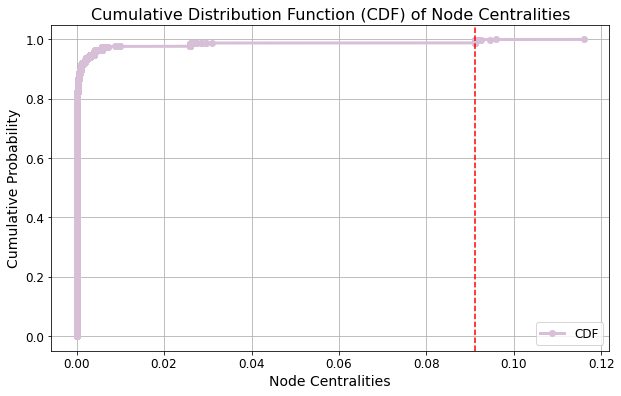

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Your node centralities
centralities = values # Include the full list

# Sort the centralities
sorted_centralities = np.sort(centralities)

# Calculate the cumulative distribution function (CDF)
cdf = np.arange(1, len(sorted_centralities) + 1) / len(sorted_centralities)

# Create a larger and nicer figure
plt.figure(figsize=(10, 6))

# Create the CDF plot with a thicker line in a lighter purple color
plt.plot(sorted_centralities, cdf, label='CDF', marker='o', linewidth=3, color='#d8bfd8', linestyle='-')

# Add labels and title with increased font size
plt.xlabel('Node Centralities', fontsize=14)
plt.ylabel('Cumulative Probability', fontsize=14)
plt.title('Cumulative Distribution Function (CDF) of Node Centralities', fontsize=16)

# Set grid, legend, and adjust tick font size
plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

threshold_cdf = 0.995
threshold_index = np.argmax(cdf >= threshold_cdf)
threshold_centrality = sorted_centralities[threshold_index]
plt.axvline(threshold_centrality, color='red', linestyle='--', label=f'CDF = {threshold_cdf}')

# Add a vertical line when CDF reaches 0.7
threshold_cdf = 0.9975
threshold_index = np.argmax(cdf >= threshold_cdf)
threshold_centrality = sorted_centralities[threshold_index]
# plt.axvline(threshold_centrality, color='red', linestyle='--', label=f'CDF = {threshold_cdf}')


# Show the plot
plt.show()


In [112]:
def nodes_above_cdf_threshold(centralities, node_names, cdf_threshold):
    """
    Returns a list of node names whose cumulative density values are above the given threshold.

    Parameters:
    - centralities (list): List of node centralities.
    - node_names (list): List of corresponding node names.
    - cdf_threshold (float): Cumulative density threshold value.

    Returns:
    - list: Nodes with cumulative density values above the threshold.
    """
    sorted_indices = np.argsort(centralities)
    sorted_cdf = np.cumsum(np.ones_like(centralities)) / len(centralities)
#     print(sorted_cdf)
    above_threshold_nodes = [node_names[i] for i in sorted_indices if sorted_cdf[i] > cdf_threshold]
    return above_threshold_nodes

# Example usage:
centralities = values
node_names = sorted_users
cdf_threshold_value = 0.995

above_cdf_threshold_nodes = nodes_above_cdf_threshold(centralities, node_names, cdf_threshold_value)
print(f"Nodes with cumulative density values above {cdf_threshold_value}: {above_cdf_threshold_nodes}")


Nodes with cumulative density values above 0.995: ['Aroba31', 'jaffry313', 'mzafar781036557', 'ash_inthehat', 'masoomarizvipk', 'SoCalBohoGal', 'shaharbanuu33', 'Heath_blahblah', 'coriinthes', 'caitecassidy', 'Ravinder_Pal3', 'SteveTh04941278', 'Meenat30', 'itratfatima72', 'investigatemag', 'goodauth', 'JustKimfromoz', 'lasersplitter', '_ayeli_', 'silascasinos', 'EimikoPosts', 'hydroglyphz', 'AndImTennisBall', 'AnilKum25570045', 'jenvanlaar', 'hijabzahraAli', 'HKX07', 'jeonnsdoII', 'Kenyans', 'stevept', 'mapleopinion', 'DavisYounts', 'BaldoOld', 'WebHeadOf616', 'WITHINSENTO', 'timxprice', 'mideastXmidwest', 'maverick7wrtin', 'lizard_scales', 'iamjoelee', 'maram0zm', 'MikhaelManekin', 'hxmza1', 'FIDDAUSI121', 'teachertabitha1', 'PeterKirstein']


Graph with 46 nodes and 40 edges


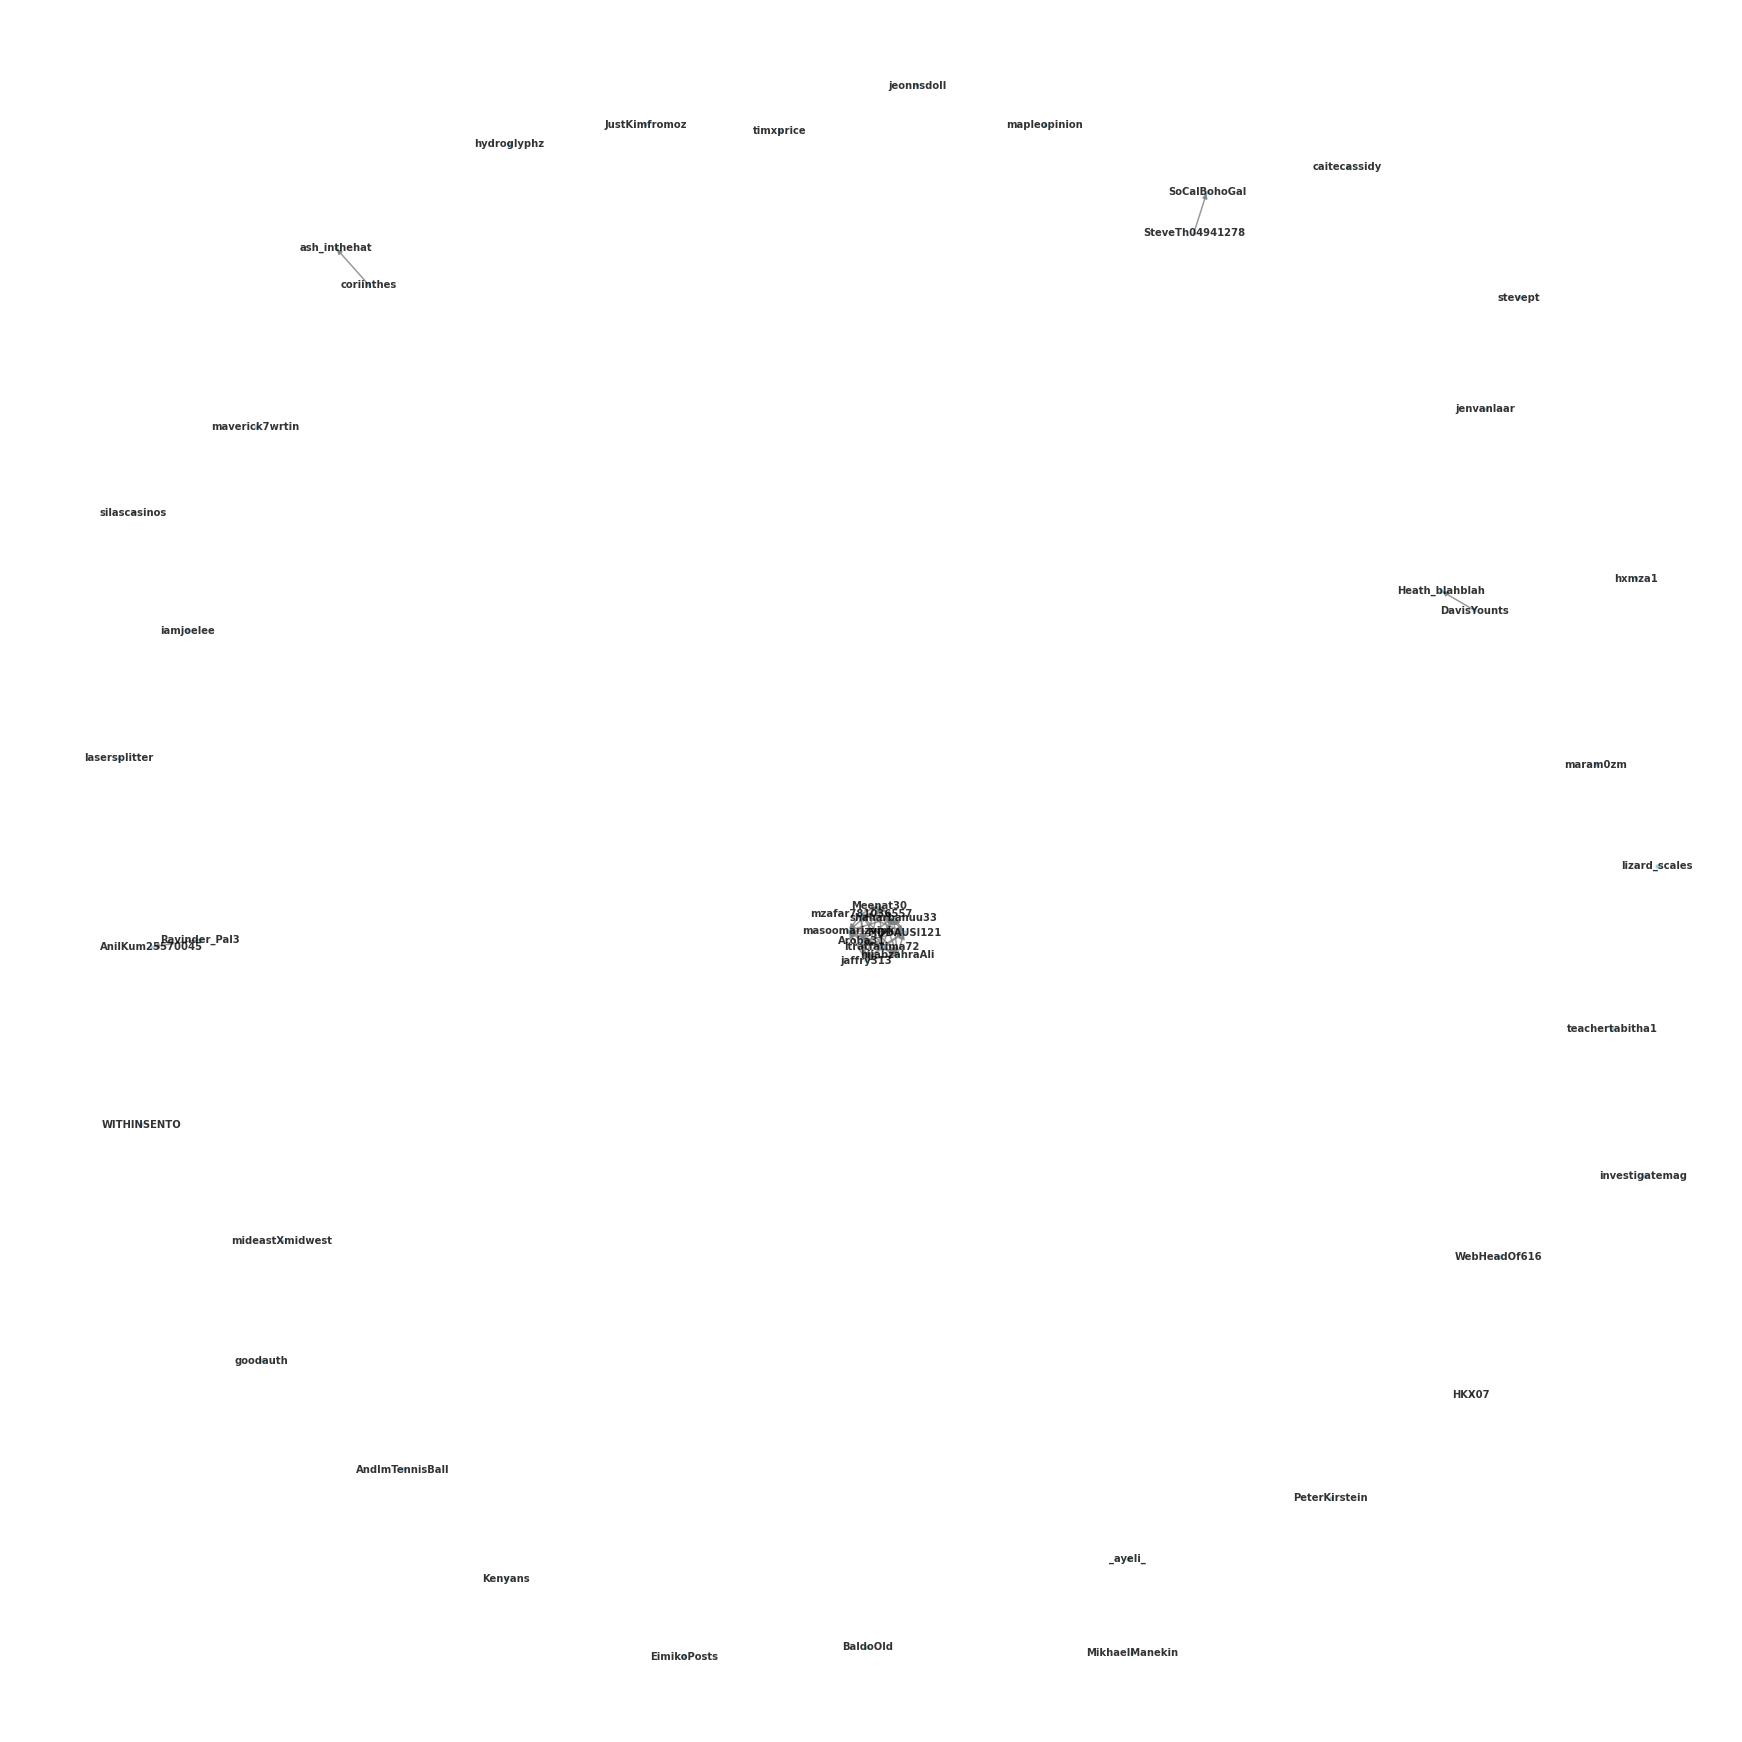

In [113]:
# users 0.9 threshold
subgraph = G.subgraph(above_cdf_threshold_nodes)

# Create a new graph with the subgraph
new_G = nx.Graph(subgraph)
print(new_G)

import matplotlib.pyplot as plt
# Define a layout for the graph (e.g., circular layout)
layout = nx.spring_layout(new_G)

plt.figure(figsize=(24,24)) 


# Draw the graph with labels
nx.draw(new_G, pos=layout, with_labels=True, arrows=True, width=1.5, font_weight='bold', node_size=10, font_size=10, node_color='skyblue', edge_color='gray', linewidths=1, alpha=0.8)

In [44]:
rel_users = retweet_data[retweet_data['orig_author_screenname'].isin(above_cdf_threshold_nodes)]

In [52]:
c = rel_users.groupby(['urls', 'orig_author_screenname', 'screen_name']).size().reset_index(name='count').sort_values(
    ['count'], ascending=False)

In [64]:
import ast
c['urls'] = c.urls.apply(lambda x: ast.literal_eval(str(x)))

In [72]:
c = c.explode('urls')
c = c.dropna(subset=['urls'])

In [75]:
c.sort_values(['count'], ascending=False)

,urls,orig_author_screenname,screen_name,count
0,https://bnn.network/world/ukraine/hamas-acknow...,SoCalBohoGal,AlphaMatrix7,1
42,https://globalnation.inquirer.net/221651/envoy...,EimikoPosts,GenderNulltral,1
262,https://twitter.com/i/web/status/1712955551724...,Ravinder_Pal3,Raj66539072,1
263,https://www.change.org/p/sign-and-share-this-u...,hydroglyphz,BigotSandwichVP,1
264,https://www.change.org/p/sign-and-share-this-u...,ash_inthehat,MishirukuJunko,1
...,...,...,...,...
23,https://globalnation.inquirer.net/221651/envoy...,EimikoPosts,BLyRor30,1
24,https://globalnation.inquirer.net/221651/envoy...,EimikoPosts,BO180214,1
25,https://globalnation.inquirer.net/221651/envoy...,EimikoPosts,BaronKain002,1
26,https://globalnation.inquirer.net/221651/envoy...,EimikoPosts,Basiljpg7,1


In [82]:
c.groupby(['urls']).size().reset_index(name='count').sort_values(['count'], ascending=False).values[2]

array(['https://palestinesupporter.com/', 9], dtype=object)

In [93]:
url_idealogies = pd.read_csv("~/Downloads/israel_domain_ideology.csv")
url_idealogies.head()

,domain,ideology,audience_var
0,kipa.co.il,0.058429,0.000935
1,israelinfo.co.il,-0.061652,0.000225
2,fathomjournal.org,-0.005293,0.000203
3,ctvnews.ca,0.041252,0.001263
4,punchng.com,0.084410,0.001444


In [92]:
tweet_urls = c.urls.values

In [99]:
for t in tweet_urls: 
    for i, _ in enumerate(url_idealogies.domain.values): 
        if _ in t: 
            print(t)
            print(url_idealogies.iloc[i].values[1])
            print(url_idealogies.iloc[i].values[2])
            print(_)

https://www.wral.com/story/sides-clash-as-unc-chapel-hill-protest-between-pro-palestine-pro-israel-groups-turns-heated/21093642/
0.100177054720079
0.0008172975715775
wral.com
https://www.timesofisrael.com/liveblog_entry/idf-says-assessment-shows-failed-islamic-jihad-rocket-launch-caused-gaza-hospital-blast/
-0.0832729762871364
0.0005804632939198
timesofisrael.com
https://www.timesofisrael.com/liveblog_entry/idf-says-assessment-shows-failed-islamic-jihad-rocket-launch-caused-gaza-hospital-blast/
-0.0832729762871364
0.0005804632939198
timesofisrael.com
https://www.timesofisrael.com/liveblog_entry/idf-says-assessment-shows-failed-islamic-jihad-rocket-launch-caused-gaza-hospital-blast/
-0.0832729762871364
0.0005804632939198
timesofisrael.com
https://twitter.com/i/web/status/1712955551724814342
-0.0716370645987296
0.0009431859979596
twitter.com
https://twitter.com/i/web/status/1711599957600583951
-0.0716370645987296
0.0009431859979596
twitter.com
https://rumble.com/v3ruymk-breaking-its-star